## Install

```
pip install qsample
```

## Prerequisites 

* This package requires Python 3.9 or higher.   
* pdflatex (for circuit rendering)  

## When to use

* Define QEC protocols that consist of one or more quantum circuits with in-sequence measurements and feed-forward of measurement information  
* Apply circuit-level incoherent Pauli noise at low physical error rates (i.e. high fidelity physical operations)
* Simulate and sample protocol execution over ranges of varying physical error rates, using customizable callbacks

## Getting started

Define a quantum protocol to sample from. In `qsample` a protocol is represented as a graph with quantum `Circuit`s as nodes and transition `checks` as edges.

To sample logical error rates of an error-corrected quantum state teleportation protocol, we define the teleportation circuit which sends the state of the first to the third qubit.

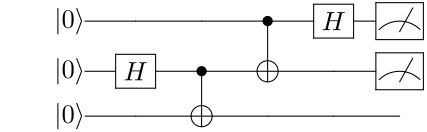

In [ ]:
from qsample.circuit import Circuit

teleport = Circuit([{"init": {0, 1, 2}},
                    {"H": {1}},
                    {"CNOT": {(1, 2)}},
                    {"CNOT": {(0, 1)}},
                    {"H": {0}},
                    {"measure": {0, 1}}])

teleport.draw()

Additionally, we need a circuit to (perfectly) measure the third qubit after running `teleport`. If the outcome of this measurement is 0 (corresponding to the initially prepared $|0\rangle$ state of qubit 1) the teleportation succeded. If the outcome is 1 however, we want to count a logical failure of this protocol.

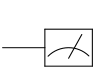

In [ ]:
meas = Circuit([{"measure": {2}}], noisy=False)

meas.draw()

Between `teleport` and `meas` apply a correction to qubit 3 conditioned on the measurement outcome (syndrome) of the teleportation circuit. We define the lookup function `lut`

In [ ]:
def lut(syn):
    op = {0: 'I', 1: 'X', 2: 'Z', 3: 'Y'}[syn]
    return Circuit([{op: {2}}], noisy=False)

Finally, define the circuit sequence and transition logic in a `Protocol`, commenced by a *START* and terminated by a *FAIL* node.

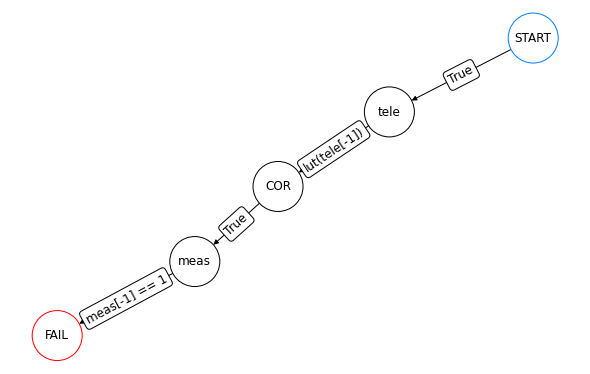

In [ ]:
from qsample.protocol import Protocol

tele_proto = Protocol(check_functions={'lut': lut})
tele_proto.add_nodes_from(['tele', 'meas'], circuits=[teleport, meas])
tele_proto.add_edge('START', 'tele', check='True')
tele_proto.add_edge('tele', 'COR', check='lut(tele[-1])')
tele_proto.add_edge('COR', 'meas', check='True')
tele_proto.add_edge('meas', 'FAIL', check='meas[-1] == 1')

tele_proto.draw(figsize=(8,5))

Notice that we do not define any initial circuit for the correction *COR* but pass our lookup function to the `check_functions` dictionary, which makes it accessible inside the `check` transition statements (edges) between circuits. This way we can dynamically insert circuits into our protocol at execution time.

After the protocol has been defined we can repeatedly execute (i.e. sample) it in the presence of incoherent noise. Let's say we are interested in the logical error rates for physical error rates on all 1- and 2-qubit gates of $p_{phy}=10^{-4}, 10^{-3}$, and $10^{-2}$. The corresponding noise model is called `E1` in qsample. The groups of all 1- and 2-qubit gates are indexed by the key *q* in `E1`.

In [ ]:
from qsample.noise import E1

err_params = {'q': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}

We are ready to sample. As our protocol only contains Clifford gates let's choose the `StabilizerSimulator`, as well as the `PlotStats` callback for plotting the resulting logical error rate as function of $p_{phy}$.

p=('1.00e-05',):   0%|          | 0/10000 [00:00<?, ?it/s]

p=('1.00e-04',):   0%|          | 0/10000 [00:00<?, ?it/s]

p=('1.00e-03',):   0%|          | 0/10000 [00:00<?, ?it/s]

p=('1.00e-02',):   0%|          | 0/10000 [00:00<?, ?it/s]

p=('1.00e-01',):   0%|          | 0/10000 [00:00<?, ?it/s]

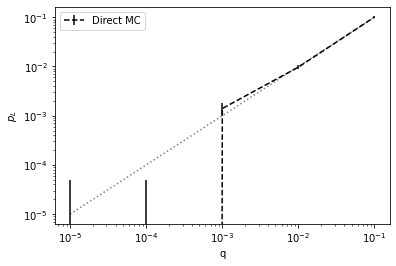

In [ ]:
from qsample.sampler.direct import DirectSampler
from qsample.sim.stabilizer import StabilizerSimulator as CHP
from qsample.callbacks import PlotStats

sam = DirectSampler(protocol=tele_proto, simulator=CHP, err_model=E1, err_params=err_params)
sam.run(n_shots=10000, callbacks=[PlotStats()])

Notice, that at low error rates `DirectSampler` performs badly, as most of the time the protocol is executed error free and, consequently, logical errors are measured infrequently. In this regime it is much more efficient to use an importance sampling strategy to avoid fault-free protocol execution and instead put more emphasis on execution with at least one fault happening. This approach is implemented in the `SubsetSampler` class. We only need to specify one additional parameter `p_max` which specifies the $p_{phy}$ at which sampling takes place. This parameter must be chosen experimentally by repeated sampling and observing which subsets have the largest impact on the failure rate. We must always choose a value such that the subset occurence probability has an exponentially falling shape. Only in this case is the scaling of the sampling results valid. Below we see that for the teleportation circuit a `p_max`-value of 0.01 and 0.1 is still okay, while 0.3 would be problematic. For more information refer to the linked publication.

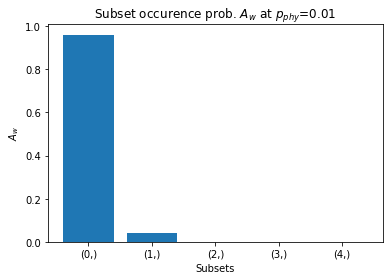

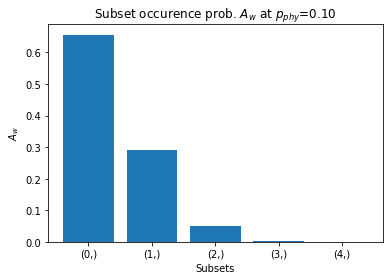

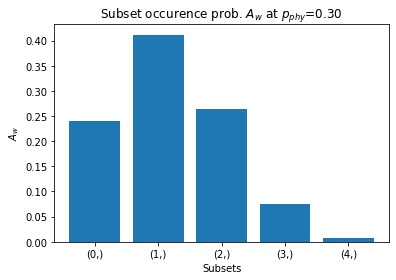

In [ ]:
import qsample.math as math

for p_phy in [0.01, 0.1, 0.3]:
    Aws = math.subset_probs(teleport, E1(), p_phy)
    plt.figure()
    plt.title("Subset occurence prob. $A_w$ at $p_{phy}$=%.2f" % p_phy)
    plt.bar(list(map(str,Aws.keys())), Aws.values())
    plt.ylabel("$A_w$")
    plt.xlabel("Subsets")

Let's choose a $p_{max}=0.1$ for the same error model as before and start sampling. (Note the significant difference in the number of samples)

p=('1.00e-01',):   0%|          | 0/500 [00:00<?, ?it/s]

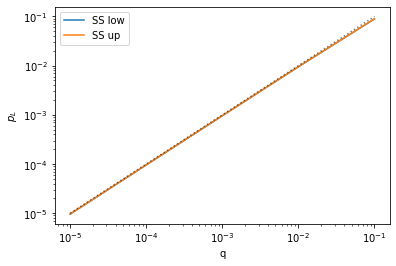

In [ ]:
from qsample.sampler.subset import SubsetSampler

ss_sam = SubsetSampler(protocol=tele_proto, simulator=CHP,  p_max={'q': 0.1}, err_model=E1, err_params=err_params)
ss_sam.run(500, callbacks=[PlotStats()])

The sampling results are internally stored by the `SubsetSampler` in a `Tree` data structure

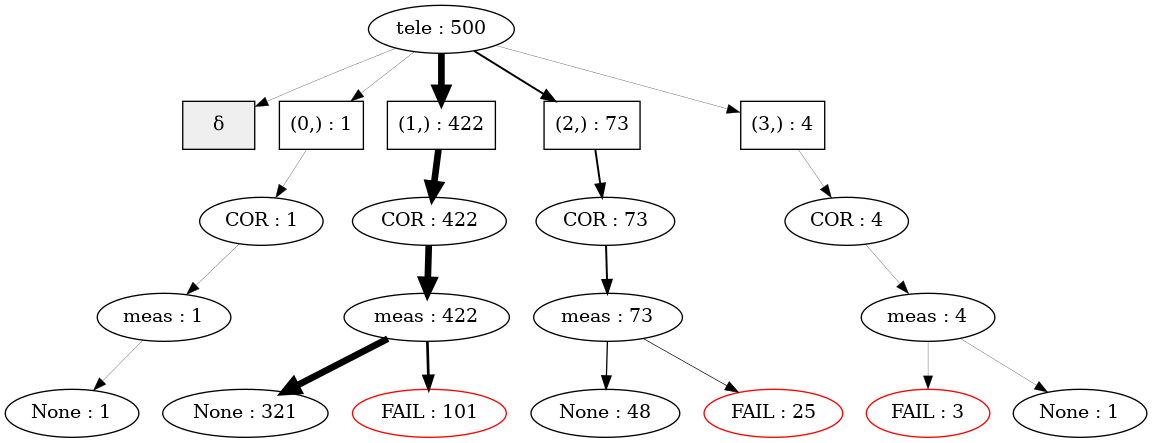

In [ ]:
ss_sam.tree.draw(verbose=True)

We see that only the teleportation protocol has fault weight subsets, while the *meas* and *COR* circuits are noise-free (ie.e no subsets). The leaf nodes *FAIL* and *None* represent logical failure and successful teleportation events, respectively. $\delta$ represents the missing subsets which have not been sampled and which result in the upper bound on the failure rate (*SS up*).

Finally, let's compare the results of `DirectSampler` and `SubsetSampler`.

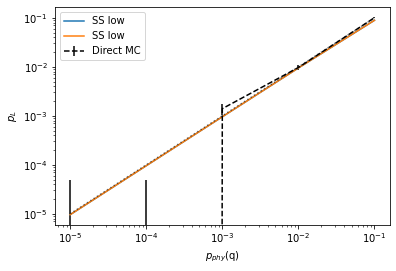

In [ ]:
p_L_low, std_low, p_L_up, std_up = ss_sam.stats()
p_L, std = sam.stats()

import matplotlib.pyplot as plt

sample_range = err_params['q']
plt.errorbar(sample_range, p_L, fmt='--', c="black", yerr=std, label="Direct MC")
plt.loglog(sample_range, p_L_low, label='SS low')
plt.fill_between(sample_range, p_L_low - std_low, p_L_low + std_low, alpha=0.2)
plt.loglog(sample_range, p_L_up, label='SS low')
plt.fill_between(sample_range, p_L_up - std_up, p_L_up + std_up, alpha=0.2)
plt.plot(sample_range, sample_range,'k:', alpha=0.5)
plt.xlabel('$p_{phy}$(q)')
plt.ylabel('$p_L$')
plt.legend();

More things to explore:
* `qsample.examples` shows more examples of protocol and protocol samplings.
* `qsample.noise` defines more complex error models, as well as a superclass `ErrorModel` which can be used to define custom error models.
* `qsample.callbacks` defines more callbacks, as well as the superclass `Callback` which allows for the implementation of custom callbacks.

## Contribute 

* Feel free to submit your feature request via github issues

## Team 

`qsample` was developed by Don Winter based on \cite{DSS} and in collaboration with Sascha Heußen under supervision of Prof. Dr. Markus Müller.